# Welcome to the first Geometric Deep Learning practical 😀

## Introduction

In this practical we will be exploring *learned* vs *enforced* invariance. Learned invariance is achieved by training general models with an augmented dataset, whereas enforced invariance refers to invariance through choice of architecture.

You will gain hands-on experience by implementing and comparing two distinct neural network models – Multi-layer Perceptron (MLP) and Convolutional Neural Network (CNN). Initially, you'll evaluate the performance of both models in their basic form, without any data augmentation. Following this, you will introduce various data augmentation techniques and observe how these enhancements impact the performance of each model.

We hope you have fun!

Authors:

Charlie Tan and Ahmed Elhag

### Overview

1. [Geometric Deep Learning Blueprint] - Theoretical motivation
2. [Learned Invariance] - Training general models with data augmentation
3. [Enforcing (Approximate) Invariance] - Employing a 'standard' CNN architecture
4. [Enforcing True Invariance (BONUS!)] - Defining an truly invariant CNN!

### Instructions

- Make a copy of this notebook.
- Make sure the GPU is turned on. Runtime -> Change runtime type -> Hardware accelerator -> GPU
- Fill in your solutions between `### SOLUTION START ###` and `### SOLUTION END ###`. Do not create additional cells.
- Please do not change the signatures of the task functions - this will make it much easier for us to help you.
- Your code should run without errors in Google Colab.

### Imports

To get started, execute the following cell to import the necessary libraries:

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Subset, DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np

In [2]:
print("Using PyTorch version:", torch.__version__)
if torch.cuda.is_available():
    print("Using GPU, device name:", torch.cuda.get_device_name(0))
    device = torch.device("cuda")
else:
    print("No GPU found, using CPU instead.")
    device = torch.device("cpu")

# set seed for pseudo-random number generation
torch.manual_seed(0)

Using PyTorch version: 2.5.1+cu124
Using GPU, device name: Tesla T4


### MNIST Dataset

The MNIST (Modified National Institute of Standards and Technology) dataset contains 70,000 images representing handwritten digits. The task is to learn a classifier that correctly identifies each of the digits. MNIST is no longer suitable as a benchmark due to its simplicity, but is ideal for running small experiments as we are today.

We now load the MNIST dataset, passing in a basic transformation to be applied as the samples are drawn.

In [3]:
# transform to convert images to pytorch tensors and normalize them
base_transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)

# download the training and test datasets
train_dataset = datasets.MNIST(
    "./data", train=True, download=True, transform=base_transform
)
test_dataset = datasets.MNIST(
    "./data", train=False, download=False, transform=base_transform
)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:11<00:00, 894kB/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 64.5kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:06<00:00, 240kB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.68MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Inspecting some of the dataset properties:

In [4]:
print(f"There are {len(train_dataset)} images in the training dataset.")
print(f"There are {len(test_dataset)} images in the test dataset.")

print(f"The shape of the images is {train_dataset[0][0].shape}.")
print(f"There are {len(train_dataset.targets.unique())} classes.")

There are 60000 images in the training dataset.
There are 10000 images in the test dataset.
The shape of the images is torch.Size([1, 28, 28]).
There are 10 classes.


Next we visualize a random selection of images from the dataset:

In [5]:
def plot_img(img, ax):
    """
    Plot a single image.

    Args:
        img (torch.Tensor): Image to plot.
        ax (matplotlib.axes.Axes): Axes to plot on.

    """
    img = img.numpy()  # convert to np array
    img = img.transpose(1, 2, 0)  # permute dimensions

    ax.imshow(img, cmap="gray", interpolation=None)  # add to plot
    ax.axis("off")

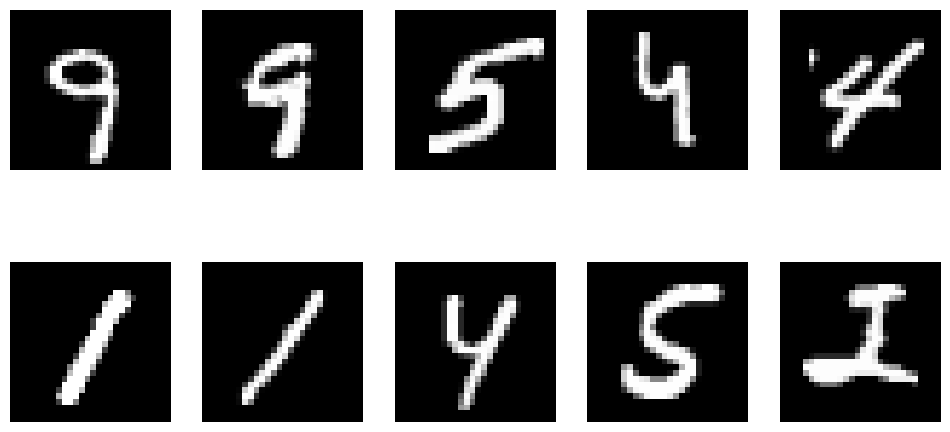

In [6]:
# axes for plotting
fig, axes = plt.subplots(2, 5, figsize=(12, 6))

for i, ax in enumerate(axes.ravel()):
    # select a random image
    img = train_dataset[int(torch.randint(len(train_dataset), (1,)))][0]

    # plot the image
    plot_img(img, ax)

plt.show()

Given the simplicity of the MNIST images, 60,000 training samples is sufficient for a multi-layer perceptron (MLP) to achieve ~99% testing accuracy without data augmentation.

To create a more challenging task on which we may evaluate the different forms of invariance, we constrain ourselves to a subset of size 250 - wherein we have 25 samples per class. To speed up experiments we also reduce the test dataset to only 1000 samples, giving an accurate but fast approximation of the 'true' test accuracy.

The following function is used to generate a balanced subset of given sizes.


In [8]:
def class_balanced_subset(dataset, subset_size):
    """
    Create a class-balanced subset of a given dataset.

    Args:
        dataset (torch.utils.data.Dataset): The original dataset.
        subset_size (int): The desired size of the subset.

    Returns:
        torch.utils.data.Subset: The class-balanced subset.

    """

    targets = dataset.targets.unique()
    num_classes = len(targets)

    assert not subset_size % num_classes
    samples_per_class = subset_size // num_classes

    subset_indices = []

    for target in targets:
        target_indices = torch.nonzero(dataset.targets == target)
        subset_indices.append(target_indices[:samples_per_class].flatten())

    subset = Subset(dataset, torch.cat(subset_indices))

    return subset


NUM_TRAIN = 250
NUM_TEST = 1000

train_subset = class_balanced_subset(train_dataset, NUM_TRAIN)
test_subset = class_balanced_subset(test_dataset, NUM_TEST)

We lastly initialize dataloaders for the train and test data, each drawing batches of size `batch_size_subset` from their respective datasets.

In [9]:
batch_size_train = 16
batch_size_test = len(test_subset) // 10  # for easy accurate accuracy calculation

train_loader = DataLoader(train_subset, batch_size_train, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size_test, shuffle=False, num_workers=2)

## Section 1: The Geometric Deep Learning Blueprint

The Geometric Deep Learning (GDL) Blueprint gives a recipe for building powerful Deep Learning models from geometric principles. The blueprint interleaves equivariant linear layers with point-wise non-linearity, in some cases pooling layers are additionally included. The last component of the blueprint is an invariant layer.

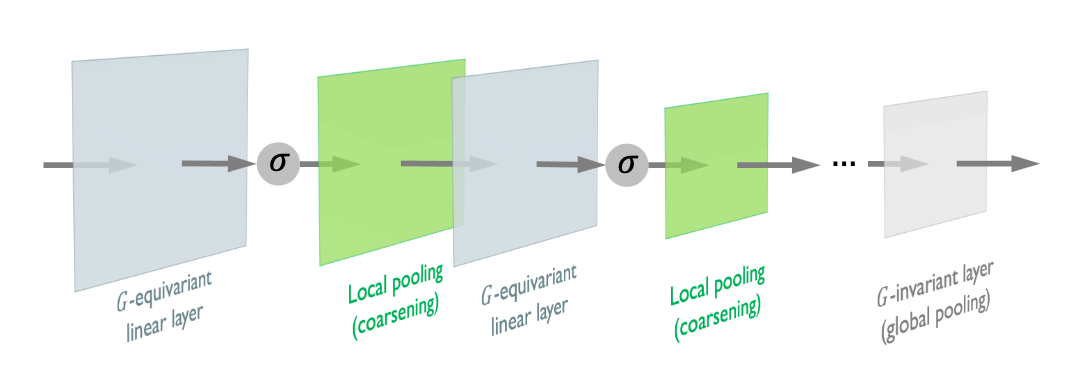

### Task 1.1:
Write a paragraph commenting on the GDL Blueprint. Consider the following questions:

*   What is the purpose of each component?
*   Why do we use the invariant layer only at the end? - What would happen if the invariant layer was placed at the start?
*   Why may we need multiple equivariant layers - possibly interleaved with pooling layers?

The Geometric Deep Learning (GDL) Blueprint structures a model in a way that aligns with underlying geometric principles. Each component plays a distinct role in this architecture. The \( G \)-equivariant linear layers ensure that the features learned by the model respect the symmetries of the problem, preserving equivariance through transformations. The pointwise non-linearity introduces non-linear feature interactions, essential for capturing complex patterns. Local pooling (or coarsening) layers aggregate information from neighboring nodes, reducing spatial resolution and computational complexity while enhancing locality-aware features. Finally, the \( G \)-invariant layer at the end computes a global representation invariant to transformations, ensuring outputs are robust to input symmetry changes.

Placing the invariant layer at the start would collapse the entire input into a global invariant representation immediately, losing valuable spatial and structural information needed for learning detailed equivariant features. This would significantly limit the model's ability to capture local patterns or hierarchical representations.

Multiple equivariant layers are essential to iteratively refine feature representations across the network. Interleaving them with pooling layers enables the model to operate at multiple resolutions, aggregating local information while maintaining global structure. This hierarchy is critical for tasks where both fine-grained and holistic understanding of data are necessary.

## Section 2: Learned Invariance

When performing image classification we are not concerned with an object's location within the image. We are therefore interested in learning a *translation-invariant* function - one that will output the same class irrespective of an object's spatial position.

One approach to solving this is to employ a *general* function class, that does not encode any geometric prior, and augment our dataset with random translations. A multi-layer perceptron composes linear transformations with non-linear activation functions, resulting in a general function class.

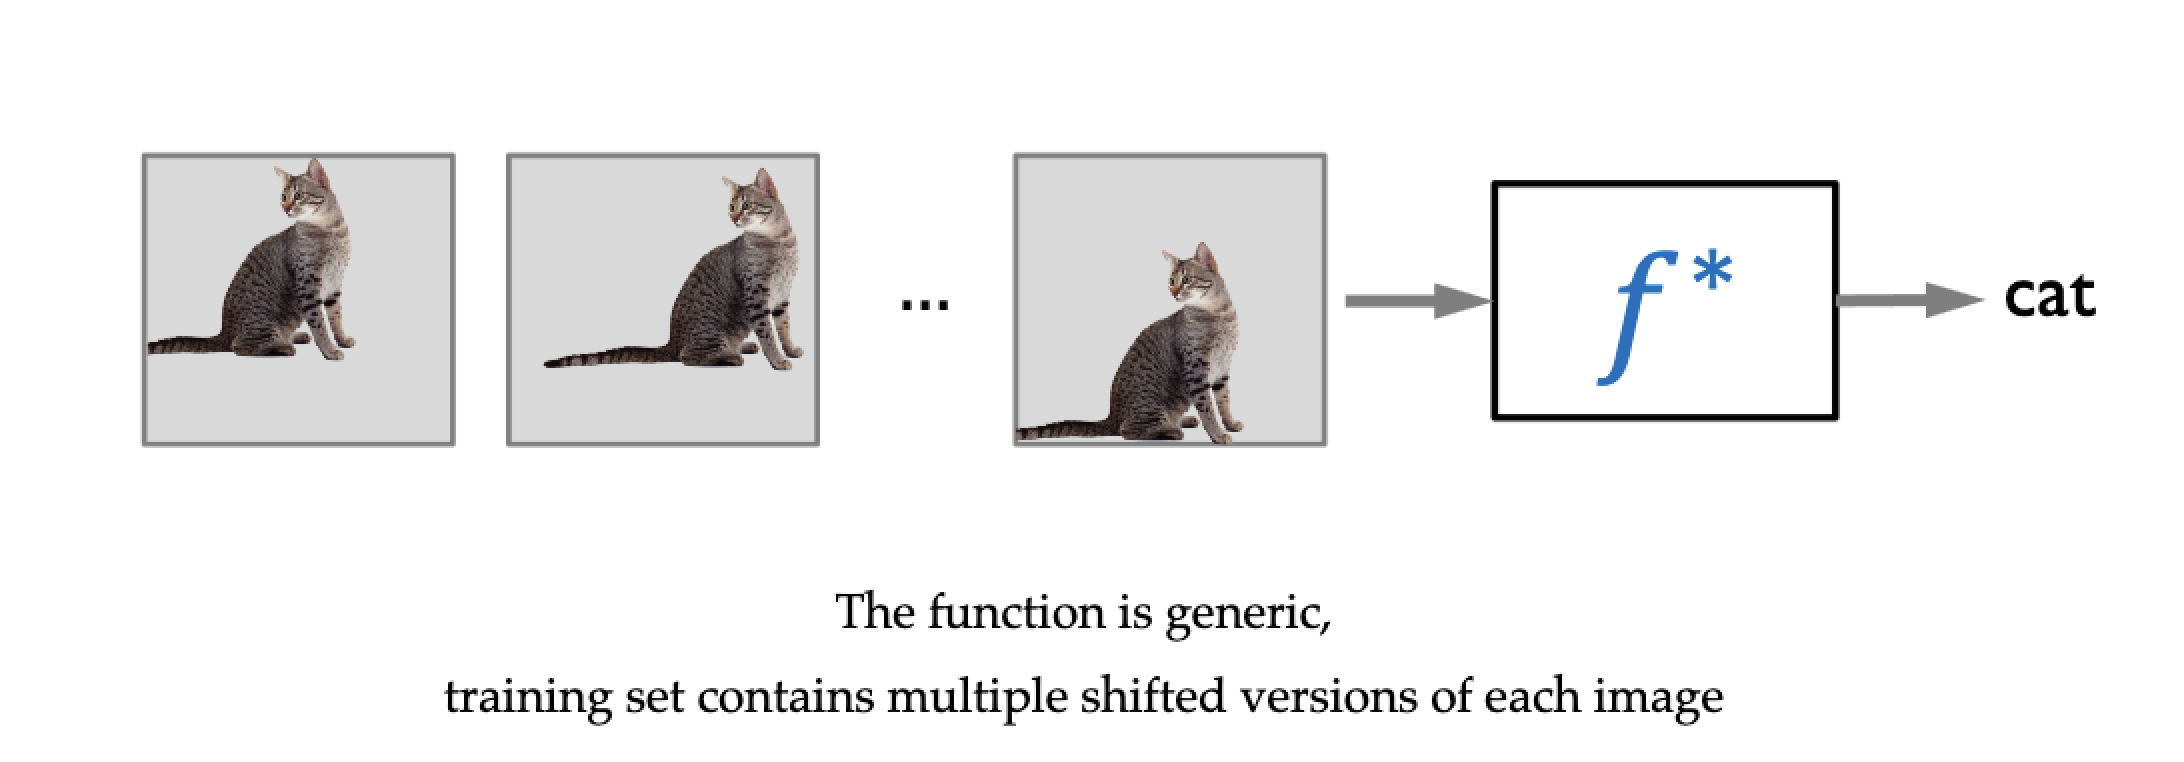

### Task 2.1

In this task, you will implement a multi-layer perceptron (MLP) in PyTorch.

The MLP model is a series of linear transformations composed with ReLU activation. The final linear layer maps to the class logits and is not followed by an activation.

The model architecture is defined by the arguments of `__init__`, where `sz_hids` defines the dimensionality of any hidden layer(s). Do not use any batch / layer normalization.

In [10]:
class MLP(nn.Module):
    """
    Multi-Layer Perceptron (MLP) model.
    """

    def __init__(self, input_shape=(1, 28, 28), sz_hids=[1024], num_classes=10):
        """
        Initialize the MLP model.

        Args:
            input_shape (tuple): Input shape, default is (1, 28, 28)
            sz_hids (list): List of hidden layer sizes, default is [1024].
            num_classes (int): Number of output classes, default is 10.

        There should be len(sz_hids) hidden layers, hence (len(sz_hids) + 1) linear layers.

        """
        super().__init__()

        ### SOLUTION START ###
        input_dim = input_shape[0] * input_shape[1] * input_shape[2]

        self.layers = nn.ModuleList()

        self.layers.append(nn.Linear(input_dim, sz_hids[0]))

        for i in range(len(sz_hids) - 1):
            self.layers.append(nn.Linear(sz_hids[i], sz_hids[i + 1]))

        self.layers.append(nn.Linear(sz_hids[-1], num_classes))

        self.activation = nn.ReLU()

        ### SOLUTION END ###

    def forward(self, x):
        """
        Forward pass of the MLP model.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor.

        """

        ### SOLUTION STARTS HERE ###
        x = x.view(x.size(0), -1)

        for layer in self.layers[:-1]:
            x = self.activation(layer(x))

        x = self.layers[-1](x)
        ### SOLUTION ENDS HERE ###

        return x

We now initialize your model and process a batch of images, asserting that we are outputting the a tensor of the correct shape.

In [11]:
model = MLP().to(device)
img = next(iter(test_loader))[0].to(device)
output = model(img)
assert output.shape == (batch_size_test, 10)

We've provided the following functions for training and evaluating our model.

In [12]:
def get_acc(outputs, labels):
    """
    Calculate the accuracy of the model predictions.

    Args:
        outputs (torch.Tensor): Model outputs.
        labels (torch.Tensor): Ground truth labels.

    Returns:
        torch.Tensor: Accuracy of the model predictions.

    """
    return (outputs.argmax(dim=1) == labels).sum().float() / outputs.shape[0]

In [13]:
def train_epoch(model, dataloader, loss_fn, opt):
    """
    Perform a single training epoch.

    Args:
        model (nn.Module): The model to train.
        dataloader (torch.utils.DataLoader): The dataloader containing the training data.
        loss_fn (Callable): The loss function to calculate the loss.
        opt (torch.optim.Optimizer): The optimizer to update the model parameters.

    Returns:
        float: Mean loss value.
        float: Mean accuracy value.

    """

    model.train()

    losses = []
    accs = []

    for data, target in dataloader:
        opt.zero_grad()  # zero gradients in the optimizer
        data, target = data.to(device), target.to(device)

        output = model(data)  # forward pass through the model
        loss = loss_fn(output, target)  # calculate the loss

        loss.backward()  # backpropagate the loss
        opt.step()  # update the model parameters

        losses.append(loss.item())
        accs.append(get_acc(output, target).item())

    mean_loss = np.mean(losses)
    mean_acc = np.mean(accs)

    return mean_loss, mean_acc

In [14]:
# decorator to disable gradient calculation during evaluation
@torch.no_grad()
def evaluate(model, dataloader, loss_fn):
    """
    Evaluate the model on the given dataloader.
    Args:

        model (nn.Module): The model to evaluate.
        dataloader (torch.utils.data.DataLoader): The dataloader containing the evaluation data.
        loss_fn (Callable): The loss function to calculate the loss.

    Returns:
        float: Mean loss value.
        float: Mean accuracy value.

    """

    model.eval()

    losses = []
    accs = []

    for data, target in dataloader:
        data, target = data.to(device), target.to(device)

        output = model(data)  # forward pass through the model
        loss = loss_fn(output, target)  # calculate the loss

        losses.append(loss.item())
        accs.append(get_acc(output, target).item())

    mean_loss = np.mean(losses)
    mean_acc = np.mean(accs)

    return mean_loss, mean_acc

In [15]:
def training_run(model, train_loader, test_loader, num_epochs=40, patience=10):
    """
    Perform a full training run.

    Args:
        model (nn.Module): The model to train.
        train_loader (torch.utils.data.DataLoader): The dataloader containing the training data.
        test_loader (torch.utils.data.DataLoader): The dataloader containing the test data.
        num_epochs (int): The number of training epochs.
        patience (int): The number of epochs to wait for improvement in test accuracy before early stopping.
    """

    loss_fn = nn.CrossEntropyLoss()
    opt = torch.optim.Adam(model.parameters(), lr=0.001)

    best_test_acc = -1
    patience_counter = 0

    for i in range(num_epochs):
        # train the model for one epoch
        train_loss, train_acc = train_epoch(model, train_loader, loss_fn, opt)

        # evaluate the model on the test data
        test_loss, test_acc = evaluate(model, test_loader, loss_fn)

        # check if the current test accuracy is better than the best test accuracy so far
        if test_acc > best_test_acc:
            best_test_acc = test_acc

            # add a message indicating a new best test accuracy
            msg = "- new best!"

            # reset the patience counter
            patience_counter = 0
        else:
            # empty message if there is no improvement in test accuracy
            msg = ""

            # increment the patience counter
            patience_counter += 1

        # print the training and test metrics for the current epoch
        print(
            f"Epoch {i+1:02d}: train loss {train_loss:.4f} train acc {train_acc:.4f} test loss {test_loss:.4f} test acc {test_acc:.4f} {msg}"
        )

        if patience_counter == patience:
            print(f"No progress after {patience} epochs - stopping early.\n")
            break

The following function is used counts the number of learnable parameters in our model:

In [16]:
def count_parameters(model):
    """
    Count the number of trainable parameters in a PyTorch model.

    Args:
        model (nn.Module): The PyTorch model.

    Returns:
        int: The number of trainable parameters.

    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

Now train the MLP you have implemented on the training data - you should reach around 82% test accuracy.

In [17]:
model = MLP().to(device)
print(f"Model contains {count_parameters(model)} trainable parameters\n")
training_run(model, train_loader, test_loader)

Model contains 814090 trainable parameters

Epoch 01: train loss 1.2704 train acc 0.5969 test loss 0.8741 test acc 0.7245 - new best!
Epoch 02: train loss 0.3191 train acc 0.8977 test loss 0.7616 test acc 0.7623 - new best!
Epoch 03: train loss 0.1373 train acc 0.9648 test loss 0.6774 test acc 0.7894 - new best!
Epoch 04: train loss 0.0540 train acc 0.9883 test loss 0.6609 test acc 0.7979 - new best!
Epoch 05: train loss 0.0215 train acc 1.0000 test loss 0.6182 test acc 0.8171 - new best!
Epoch 06: train loss 0.0113 train acc 1.0000 test loss 0.6478 test acc 0.8155 
Epoch 07: train loss 0.0081 train acc 1.0000 test loss 0.6560 test acc 0.8140 
Epoch 08: train loss 0.0064 train acc 1.0000 test loss 0.6567 test acc 0.8128 
Epoch 09: train loss 0.0051 train acc 1.0000 test loss 0.6631 test acc 0.8155 
Epoch 10: train loss 0.0044 train acc 1.0000 test loss 0.6709 test acc 0.8142 
Epoch 11: train loss 0.0037 train acc 1.0000 test loss 0.6738 test acc 0.8142 
Epoch 12: train loss 0.0032 trai

With our MLP defined and a baseline accuracy with which to compare, we now proceed to train using translations as data augmentation.

The following cell defines a dataloader in which random translations are applied to the images as they are sampled by the dataloader.

In [18]:
# the new transform is the composition of our random translation and the base transform
translate_transform = transforms.Compose(
    [transforms.RandomCrop((28, 28), 2), base_transform]
)

# new train_subset with the augmented transform
train_dataset_translate = datasets.MNIST(
    "./data", train=True, download=True, transform=translate_transform
)
train_subset_translate = class_balanced_subset(train_dataset_translate, NUM_TRAIN)

# new train_loader
train_loader_translate = DataLoader(
    train_subset_translate, batch_size_train, shuffle=True, num_workers=2
)

### Task 2.2

Train your MLP on this augmented dataset - discuss the results in relation to the previous experiment.

In [19]:
model = MLP().to(device)
print(f"Model contains {count_parameters(model)} trainable parameters\n")
training_run(model, train_loader_translate, test_loader)

Model contains 814090 trainable parameters

Epoch 01: train loss 1.8545 train acc 0.3922 test loss 1.0775 test acc 0.6614 - new best!
Epoch 02: train loss 1.1039 train acc 0.6703 test loss 0.8929 test acc 0.7055 - new best!
Epoch 03: train loss 1.0369 train acc 0.6625 test loss 0.8527 test acc 0.7164 - new best!
Epoch 04: train loss 0.7581 train acc 0.7414 test loss 0.7974 test acc 0.7508 - new best!
Epoch 05: train loss 0.6917 train acc 0.7453 test loss 0.7781 test acc 0.7619 - new best!
Epoch 06: train loss 0.6224 train acc 0.8195 test loss 0.7302 test acc 0.7590 
Epoch 07: train loss 0.5071 train acc 0.8469 test loss 0.7047 test acc 0.7726 - new best!
Epoch 08: train loss 0.4767 train acc 0.8414 test loss 0.6704 test acc 0.8003 - new best!
Epoch 09: train loss 0.4220 train acc 0.8883 test loss 0.6456 test acc 0.7936 
Epoch 10: train loss 0.3642 train acc 0.9117 test loss 0.5543 test acc 0.8281 - new best!
Epoch 11: train loss 0.4239 train acc 0.8875 test loss 0.6596 test acc 0.7939 

Answer here...

## Section 3: Enforcing (Approximate) Invariance

We have just seen that applying data augmentation when training a general function class enables us to learn a better classifier. The GDL Blueprint provides another solution, wherein our learnable function $f$ is *a priori* assumed to be shift-invariant.


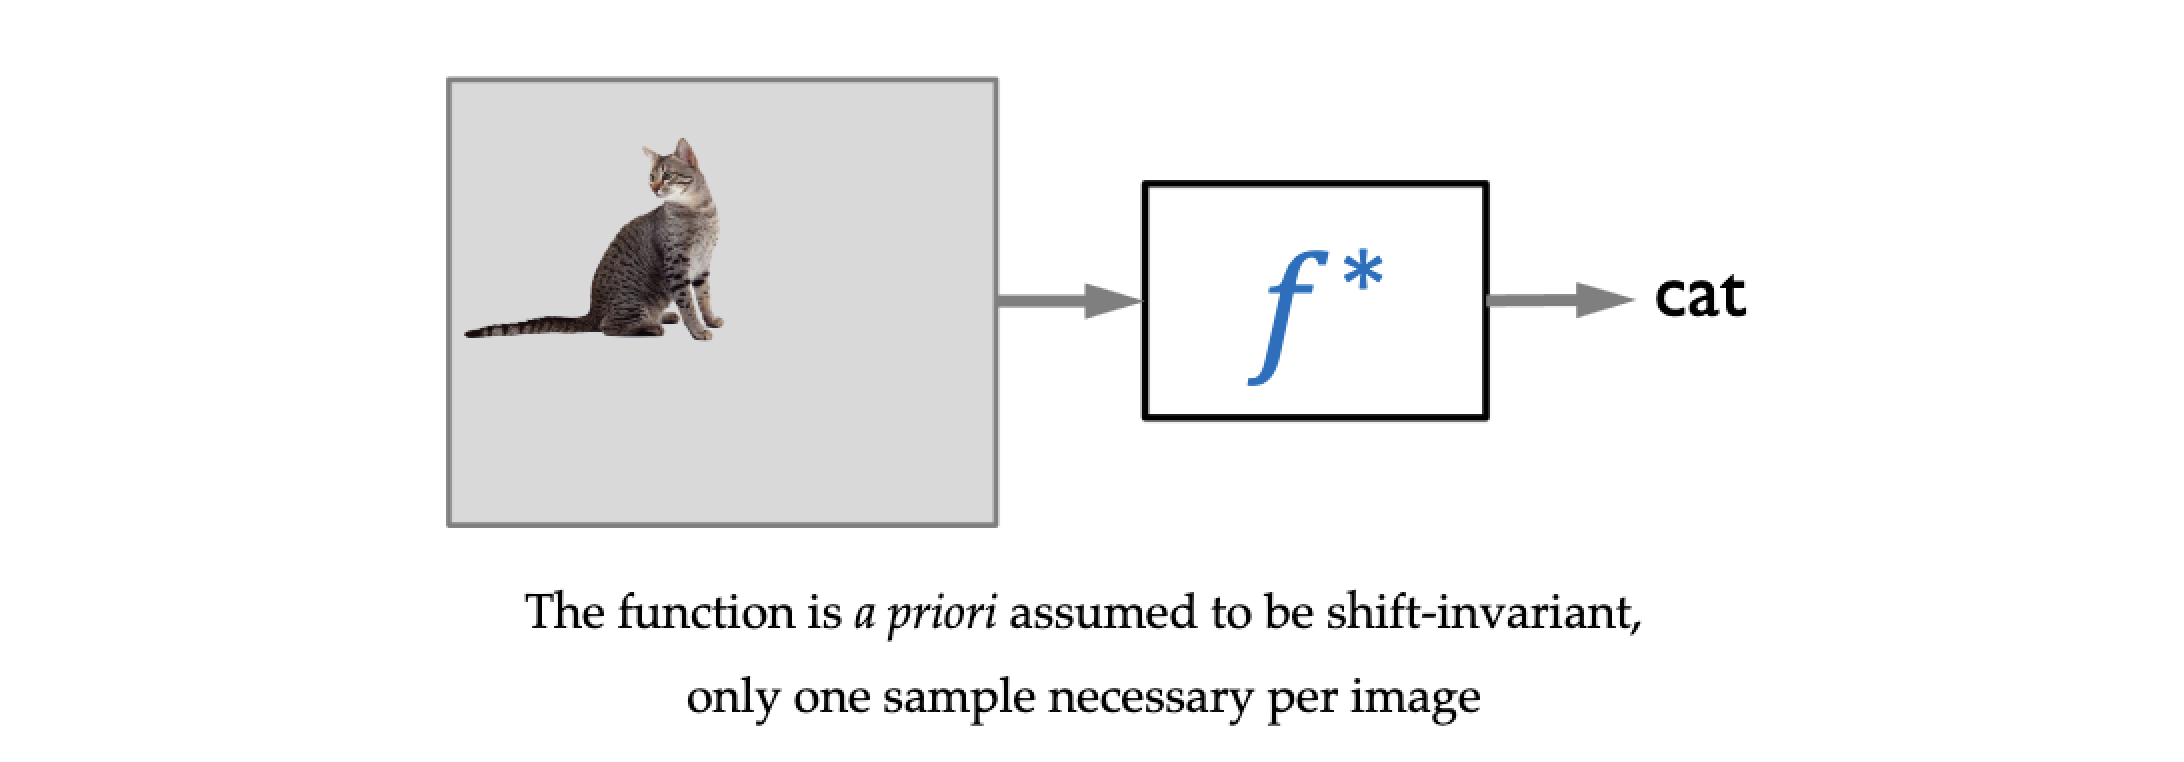

The discrete convolution is equivariant to (circular) shifts, and is the building block of a convolutional neural network (CNN). The shift equivariance of the convolution operation will be covered in the week 3 lecture, and is also discussed in Section 4.2 of [Geometric Deep Learning Grids, Groups, Graphs, Geodesics and Gauges](https://arxiv.org/pdf/2104.13478.pdf).

Discrete convolutions are equivalent to left multiplication by a *circulant matrix*. Given a vector $\mathbf{\theta} = (\theta_0,...,\theta_{n-1})$, the circulant matrix $\mathbf{C}(\mathbf{\theta})$ is defined as:

$$
C(\mathbf{\theta}) =
\begin{bmatrix}
    \theta_{0} & \theta_{1} & & & \theta_{n-1} \\
    \theta_{n-1} & \theta_{0} & \theta_{1} & &\\
    & \ddots & \ddots & \ddots &\\
    &  & \theta_{n-1} & \theta_{0} & \theta_{1}\\
    \theta_{1} &  & & \theta_{n-1} & \theta_{0}\\
\end{bmatrix}
$$

Left multiplication by the circulant matrix $\mathbf{C}(\mathbf{\theta})$ is equivalent to performing (circular) discrete convolution by the vector $\mathbf{\theta}$.

$$\mathbf{C}(\mathbf{\theta})\mathbf{z} = \mathbf{z}  \star \mathbf{\theta} $$

### Task 3.1

Where $\mathbf{\theta} = (0,1,0,...,0)$, the circulant matrix is known as the (right) shift matrix $\mathbf{S} = \mathbf{C}(\mathbf{\theta})$

Prove that a matrix $\mathbf{X}$ is circulant if it commutes with $\mathbf{S}$.

Hint: expand the matrix multiplication $\mathbf{S} \mathbf{X} = \mathbf{X} \mathbf{S}$ element-wise.

(An image of a handwritten proof is sufficient)


1. The product  $\mathbf{S} \mathbf{X}$ shifts the rows of $\mathbf{X}$ circularly:
   $
   (\mathbf{S} \mathbf{X})_{ij} = X_{(i-1)j}, \quad \text{with circular indexing: } i-1 \to n \text{ if } i = 1.
   $

2. The product $\mathbf{X} \mathbf{S}$ shifts the columns of $\mathbf{X}$ circularly:
   $
   (\mathbf{X} \mathbf{S})_{ij} = X_{i(j-1)}, \quad \text{with circular indexing: } j-1 \to n \text{ if } j = 1.
   $

3. If $\mathbf{S} \mathbf{X} = \mathbf{X} \mathbf{S} $, then:
  $
   X_{(i-1)j} = X_{i(j-1)}, \quad \forall i, j.
  $

4. By induction:
   - For $i = 1$, the equation implies each row of $\mathbf{X}$ is a circular shift of the row above it.
   - Thus, $\mathbf{X}$ is circulant.


### Task 3.2

Now after benchmarking the MLP, we will implement a Convolution Neural Network (CNN) model with the following architecture:

Convolution\
ReLU\
MaxPool (subsample by factor of 2)\
Convolution\
ReLU\
MaxPool (subsample by factor of 2)\
Convolution\
ReLU\
Flatten\
Linear

The argument `feature_dims` defines the feature map dimension of each convolutional layer. Do not use any batch / layer normalization.

In [20]:
class CNN(nn.Module):
    """
    Convolutional Neural Network (CNN) model.
    """

    def __init__(
        self, input_shape=(1, 28, 28), feature_dims=[64, 64, 32], num_classes=10
    ):
        """
        Initialize the CNN model.

        Args:
            input_shape (tuple): The shape of the input tensor, default is (1, 28, 28).
            feature_dims (list): List of feature dimensions, default is [64, 64, 32].
            num_classes (int): Number of output classes, default is 10.

        There should be len(feature_dims) convolutional layers and a single linear layer.

        """

        super().__init__()

        ### SOLUTION START ###
        layers = []

        in_channels = input_shape[0]

        for feature_dim in feature_dims:
            layers.append(nn.Conv2d(in_channels, feature_dim, kernel_size=3, padding=1))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            in_channels = feature_dim

        self.conv_layers = nn.Sequential(*layers)

        conv_output_shape = (
            input_shape[1] // (2 ** len(feature_dims)),
            input_shape[2] // (2 ** len(feature_dims)),
        )
        flattened_dim = feature_dims[-1] * conv_output_shape[0] * conv_output_shape[1]

        self.fc = nn.Linear(flattened_dim, num_classes)
        ### SOLUTION END ###

    def forward(self, x):
        """
        Forward pass of the CNN model.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor.

        """

        ### SOLUTION START ###
        x = self.conv_layers(x)

        x = x.view(x.size(0), -1)

        x = self.fc(x)
        ### SOLUTION END ###

        return x

We now initialize your model and process a batch of images, asserting that we are outputting the a tensor of the correct shape.

In [21]:
model = CNN().to(device)
img = next(iter(test_loader))[0].to(device)
output = model(img)
assert output.shape == (batch_size_test, 10)

### Task 3.3

Train the CNN on the original (no augmentation) dataset - you should achieve around 87% test accuracy. Discuss this result in relation to the previous experiments.

In [22]:
model = CNN().to(device)
print(f"Model contains {count_parameters(model)} trainable parameters\n")
training_run(model, train_loader, test_loader)

Model contains 58922 trainable parameters

Epoch 01: train loss 2.2357 train acc 0.2008 test loss 2.0630 test acc 0.3445 - new best!
Epoch 02: train loss 1.6692 train acc 0.5117 test loss 1.2646 test acc 0.5996 - new best!
Epoch 03: train loss 0.8808 train acc 0.7586 test loss 0.8982 test acc 0.7104 - new best!
Epoch 04: train loss 0.5099 train acc 0.8477 test loss 0.6957 test acc 0.7841 - new best!
Epoch 05: train loss 0.2780 train acc 0.9375 test loss 0.5540 test acc 0.8199 - new best!
Epoch 06: train loss 0.2016 train acc 0.9609 test loss 0.5555 test acc 0.8293 - new best!
Epoch 07: train loss 0.1371 train acc 0.9625 test loss 0.6283 test acc 0.8182 
Epoch 08: train loss 0.1061 train acc 0.9664 test loss 0.5187 test acc 0.8520 - new best!
Epoch 09: train loss 0.0749 train acc 0.9844 test loss 0.5073 test acc 0.8548 - new best!
Epoch 10: train loss 0.0375 train acc 0.9961 test loss 0.4983 test acc 0.8551 - new best!
Epoch 11: train loss 0.0290 train acc 0.9961 test loss 0.4282 test a

Answer here...

### Task 3.4

Write a short paragraph discussing how this CNN architecture fails to achieve exact invariance to translation.

Run the CNN on the translation-augmented dataset as defined earlier. Why does this further increase the performance?

In [23]:
model = CNN().to(device)
print(f"Model contains {count_parameters(model)} trainable parameters\n")
training_run(model, train_loader_translate, test_loader)

Model contains 58922 trainable parameters

Epoch 01: train loss 2.3115 train acc 0.1211 test loss 2.1990 test acc 0.3419 - new best!
Epoch 02: train loss 2.0594 train acc 0.4047 test loss 1.6564 test acc 0.6181 - new best!
Epoch 03: train loss 1.3895 train acc 0.6133 test loss 1.0403 test acc 0.6331 - new best!
Epoch 04: train loss 0.8600 train acc 0.7172 test loss 0.6436 test acc 0.7982 - new best!
Epoch 05: train loss 0.6687 train acc 0.7781 test loss 0.5269 test acc 0.8354 - new best!
Epoch 06: train loss 0.4599 train acc 0.8844 test loss 0.4012 test acc 0.8822 - new best!
Epoch 07: train loss 0.3870 train acc 0.8953 test loss 0.4074 test acc 0.8731 
Epoch 08: train loss 0.3858 train acc 0.8844 test loss 0.3687 test acc 0.8881 - new best!
Epoch 09: train loss 0.2503 train acc 0.9180 test loss 0.2965 test acc 0.9088 - new best!
Epoch 10: train loss 0.2350 train acc 0.9258 test loss 0.3721 test acc 0.8768 
Epoch 11: train loss 0.2188 train acc 0.9492 test loss 0.3216 test acc 0.8958 



CNNs are not exactly translation-invariant because pooling and fully connected layers break the translation-equivariance of convolutional layers. Training on translation-augmented data improves performance by teaching the model to associate consistent outputs with shifted inputs, making it more robust to spatial variations.

For some tasks / datasets in computer vision it is also desirable to be invariant to rotation. We will now train our CNN using random rotations as data augmentation.

The following code defines a dataloader augmented with random rotations:

In [24]:
# the new transform is the composition of our random rotations and the base transform
rotate_transform = transforms.Compose([transforms.RandomRotation(180), base_transform])

# new train_subset with the augmented transform
train_dataset_rotate = datasets.MNIST(
    "./data", train=True, download=True, transform=rotate_transform
)
train_subset_rotate = class_balanced_subset(train_dataset_rotate, NUM_TRAIN)

# new train_loader
train_loader_rotate = DataLoader(
    train_subset_rotate, batch_size_train, shuffle=True, num_workers=2
)

### Task 3.5

Would you expect random rotations to enhance the performance of our CNN on MNIST classification?

Train the CNN on this augmented dataset - discuss your findings - was your prediction correct? Try modifying the range of rotations in the augmentation, does this have any effect?

In [25]:
model = CNN().to(device)
print(f"Model contains {count_parameters(model)} trainable parameters\n")
training_run(model, train_loader_rotate, test_loader)

Model contains 58922 trainable parameters

Epoch 01: train loss 2.3265 train acc 0.0938 test loss 2.2718 test acc 0.2237 - new best!
Epoch 02: train loss 2.2709 train acc 0.1406 test loss 2.2272 test acc 0.2106 
Epoch 03: train loss 2.1919 train acc 0.2133 test loss 2.1095 test acc 0.2331 - new best!
Epoch 04: train loss 2.0242 train acc 0.2852 test loss 1.9183 test acc 0.3304 - new best!
Epoch 05: train loss 1.8922 train acc 0.3461 test loss 1.7790 test acc 0.3660 - new best!
Epoch 06: train loss 1.7901 train acc 0.3352 test loss 1.6525 test acc 0.4442 - new best!
Epoch 07: train loss 1.5113 train acc 0.5234 test loss 1.5579 test acc 0.4366 
Epoch 08: train loss 1.3923 train acc 0.5437 test loss 1.7231 test acc 0.3951 
Epoch 09: train loss 1.2991 train acc 0.5398 test loss 1.3982 test acc 0.5374 - new best!
Epoch 10: train loss 1.2386 train acc 0.5563 test loss 1.2961 test acc 0.5401 - new best!
Epoch 11: train loss 1.1410 train acc 0.6430 test loss 1.2516 test acc 0.5671 - new best!


not that much of an improvemtn both bcz maybe the test set is not rotated and also notion of 6 and 9 etc .

## Section 4: Enforcing True Invariance (BONUS!)

As discussed in task 3.4 the CNN implemented earlier isn't really invariant to translations (it is however typical of a convolutional image classifier).

This is demonstrated using the following code, which tests for invariance to (circular) translations.


In [ ]:
def invariance_test(model, img):
    """
    Test the invariance of a given model by comparing its output with the output of the same model
    applied to a shifted version of the input image.

    Args:
        model (nn.Module): The model to test for invariance.
        img (torch.Tensor): The input image to test.

    Returns:
        None: Prints whether the model is invariant or not.

    """

    output = model(img)  # output with original input

    img_pad = F.pad(
        img, (2, 2, 2, 2), mode="circular"
    )  # pad the image with circular padding
    img_shift = transforms.functional.crop(
        img_pad, 0, 0, 28, 28
    )  # crop the image to the original size at different position

    output_shift = model(img_shift)  # output with shifted input

    invariance = torch.equal(output, output_shift)

    print(f"Model is invariant: {invariance}")

In [ ]:
model = CNN().to(device)
img = next(iter(test_loader))[0][0:1].to(device)
invariance_test(model, img)

However, we know that the convolution operation is equivariant to (hint - circular) convolutions - so can we make a CNN architecture that passes the above test?

### Task 4.1

Implement an Invariant CNN in the class below.

We are not defining the architecture, you are free to explore different architectures provided you:
1. Pass the invariance test
2. Reach 80% accuracy on our MNIST subset (without augmentations!)

As a hint the `__init__` default arguments describe that these criteria can be met using three convolutional layers each with 64 kernels.

We additionally did not use any batch / layer normalization, nor dropout.

In [ ]:
class InvariantCNN(nn.Module):
    """
    Convolutional Neural Network (CNN) model that is invariant to circular shifts of input image.
    """

    def __init__(
        self, input_shape=(1, 28, 28), feature_dims=[64, 64, 64], num_classes=10
    ):
        """
        Initialize the InvariantCNN model.

        Args:
            input_shape (tuple): The shape of the input tensor, default is (1, 28, 28).
            feature_dims (list): List of feature dimensions, default is [64, 64, 64].
            num_classes (int): Number of output classes, default is 10.

        There should be len(feature_dims) convolutional layers and a single linear layer.

        """

        super().__init__()

        ### SOLUTION STARTS HERE ###

        ### SOLUTION ENDS HERE ###

    def forward(self, x):
        """
        Forward pass of the CNN model.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor.

        """

        ### SOLUTION STARTS HERE ###

        ### SOLUTION ENDS HERE ###

        return x

Now we test for invariance!

In [ ]:
inv_cnn = InvariantCNN().to(device)
img = next(iter(test_loader))[0][0:1].to(device)
invariance_test(inv_cnn, img)

And lastly we train and evaluate on our training subset.

In [ ]:
model = InvariantCNN().to(device)
print(f"Model contains {count_parameters(model)} trainable parameters\n")
training_run(model, train_loader, test_loader)

### Task 4.2

Discuss the results from the Invariant CNN experiment - why do we not perform as well as the previous CNN architecture?

Answer here...